In [ ]:
import numpy as np
import pandas as pd

In [ ]:
raw_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/MSCI 641 Text Analytics/labeled_data.csv')
dataset = raw_data.drop(columns=['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'], axis=1)

count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).

hate_speech = number of CF users who judged the tweet to be hate speech.

offensive_language = number of CF users who judged the tweet to be offensive.

neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.

class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither

In [ ]:
raw_data['count'].unique()

array([3, 6, 9, 4, 7])

In [ ]:
dataset.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
dataset.columns = ['label', 'body_text']
dataset.head()

,label,body_text
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
import nltk
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

dataset['body_len'] = dataset['body_text'].apply(lambda x: len(x) - x.count(" "))
dataset['punct%'] = dataset['body_text'].apply(lambda x: count_punct(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
dataset.head()

,label,body_text,body_len,punct%
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,116,10.3
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,70,17.1
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,100,15.0
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,54,27.8
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,112,16.1


In [ ]:
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

In [ ]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text, min_df=5)
X_tfidf = tfidf_vect.fit_transform(dataset['body_text'])
X_features = pd.concat([dataset['body_len'], dataset['punct%'], pd.DataFrame(X_tfidf.toarray())], axis=1)
X_features.head()

,body_len,punct%,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,4171,4172,4173,4174,4175,4176,4177,4178,4179,4180,4181,4182,4183,4184,4185,4186,4187,4188,4189,4190,4191,4192,4193,4194,4195,4196,4197,4198,4199,4200,4201,4202,4203,4204,4205,4206,4207,4208,4209,4210
0,116,10.3,0.229057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,70,17.1,0.230121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100,15.0,0.242063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,54,27.8,0.323913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,112,16.1,0.235750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
rf = RandomForestClassifier(n_jobs=-1)
k_fold = KFold(n_splits=5)
cross_val_score(rf, X_features, dataset['label'], cv=k_fold, scoring='accuracy')

array([0.86947751, 0.8642324 , 0.91890256, 0.91343826, 0.90879742])

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, dataset['label'], test_size=0.2)

In [ ]:
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(19826, 4213)
(4957, 4213)
(19826,)
(4957,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50, max_depth=50, n_jobs=-1)
rf_model = rf.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = rf_model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8579786160984466


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

              precision    recall  f1-score   support

           0       0.75      0.01      0.02       306
           1       0.86      0.99      0.92      3776
           2       0.88      0.60      0.71       875

    accuracy                           0.86      4957
   macro avg       0.83      0.53      0.55      4957
weighted avg       0.85      0.86      0.82      4957



[Text(0, 0.5, 'Hate'), Text(0, 1.5, 'Offensive'), Text(0, 2.5, 'Neither')]

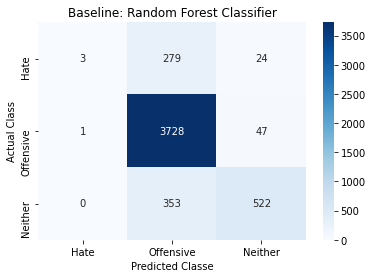

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels= [0, 1, 2])

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues'); #annot=True to annotate cells

# labels, title and ticks

ax.set_xlabel('Predicted Classe')
ax.set_ylabel('Actual Class')
ax.set_title('Baseline: Random Forest Classifier') 
ax.xaxis.set_ticklabels(['Hate', 'Offensive', 'Neither'])
ax.yaxis.set_ticklabels(['Hate', 'Offensive', 'Neither'])

In [ ]:
cm

array([[   3,  279,   24],
       [   1, 3728,   47],
       [   0,  353,  522]])

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
nb = MultinomialNB()
nb_model = nb.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8410328827920113

In [ ]:
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

              precision    recall  f1-score   support

           0       1.00      0.00      0.01       275
           1       0.84      0.99      0.91      3848
           2       0.87      0.44      0.58       834

    accuracy                           0.84      4957
   macro avg       0.90      0.48      0.50      4957
weighted avg       0.85      0.84      0.80      4957

